In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import umap

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.linear_model import LogisticRegression

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

In [3]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

In [4]:
train_idx = np.random.choice(normed.T.index.values, size=np.int(np.floor(len(normed.columns) / 3 * 2))).tolist()
test_idx = [n for n in normed.T.index if n not in train_idx]

train_exp = normed.T[normed.T.index.isin(train_idx)]
train_labels = meta[meta.ID.isin(train_idx)].cancer 

test_exp = normed.T[normed.T.index.isin(test_idx)]
test_labels = meta[meta.ID.isin(test_idx)].cancer 

In [5]:
c = np.linspace(0.01, .99, 20)
models = {}

# run through a variety of sparsity values
for ci in c:
    model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=ci,
        max_iter=5000)
    model.fit(train_exp, train_labels)
    models[ci] = model

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/

Loss is minimized at 0.113
Out of the box performance is: 0.84
Fraction of Luminal_A in test set: 0.65


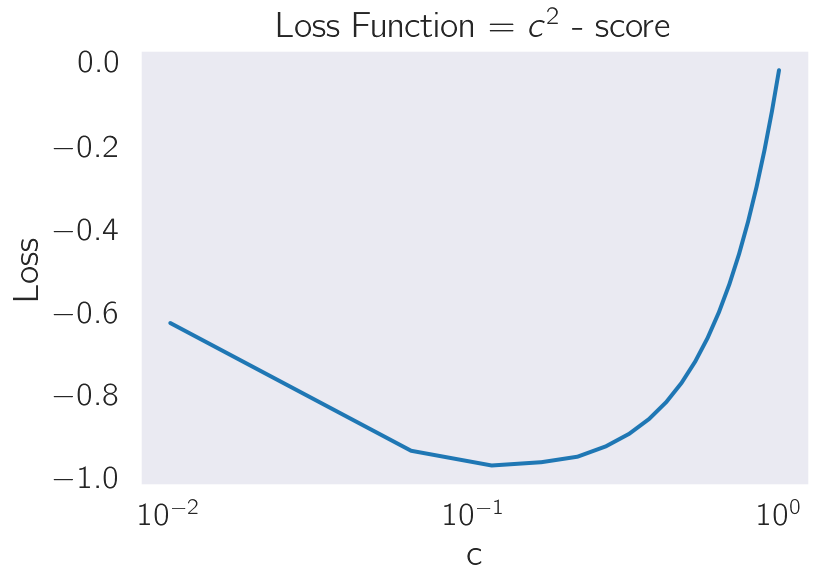

In [6]:
loss = lambda x: x **2 - models[x].score(train_exp, train_labels)
# calculate loss function
l = np.array([loss(ci) for ci in c])
# find minimizing c value for loss:
cval = c[np.argmin(l)]

plt.plot(c, l)
plt.title('Loss Function = $c^2$ - score')
plt.xlabel('c')
plt.ylabel('Loss')
plt.xscale('log')

print('Loss is minimized at {0:.3g}'.format(c[np.argmin(l)]))
print('Out of the box performance is: {0:.2g}'.format(models[cval].score(test_exp, test_labels)))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test_labels == 'Luminal_A').sum() / len(test_labels)))

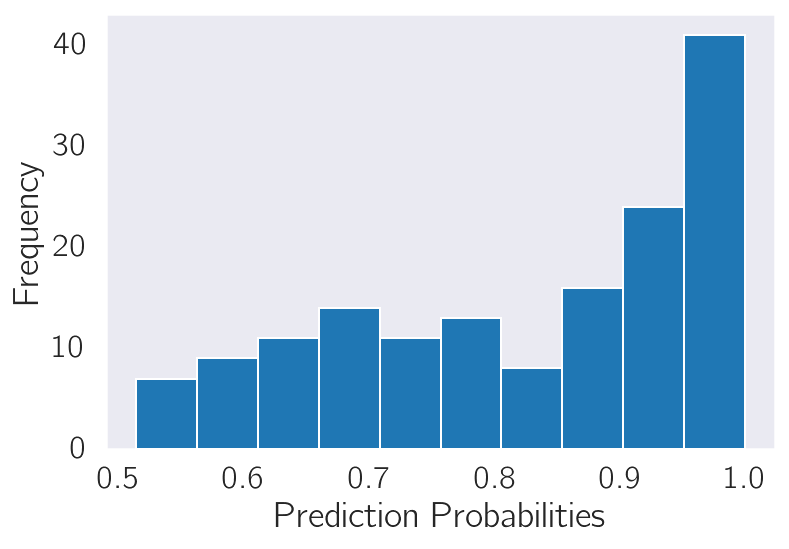

In [7]:
plt.hist(models[cval].predict_proba(test_exp).max(axis=1))
plt.xlabel('Prediction Probabilities')
_ = plt.ylabel('Frequency')

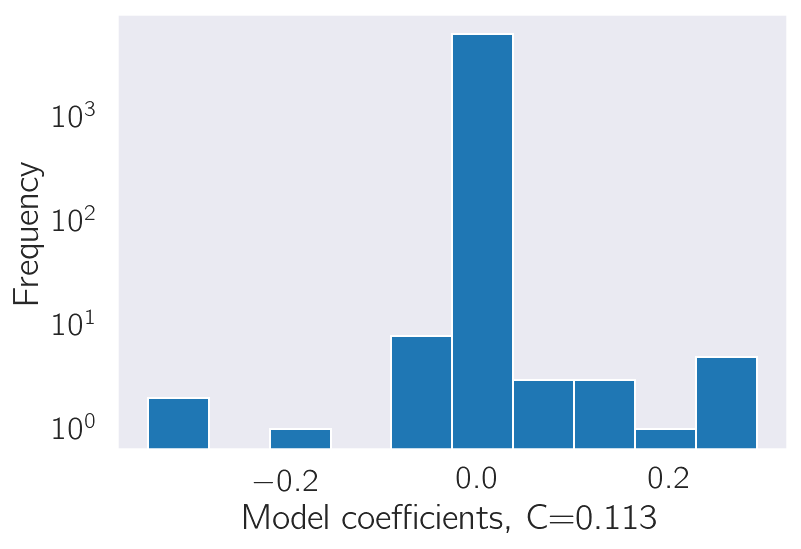

In [8]:
plt.hist(models[cval].coef_[0])
plt.yscale('log')
plt.xlabel('Model coefficients, C={0:.3g}'.format(cval))
_ = plt.ylabel('Frequency')

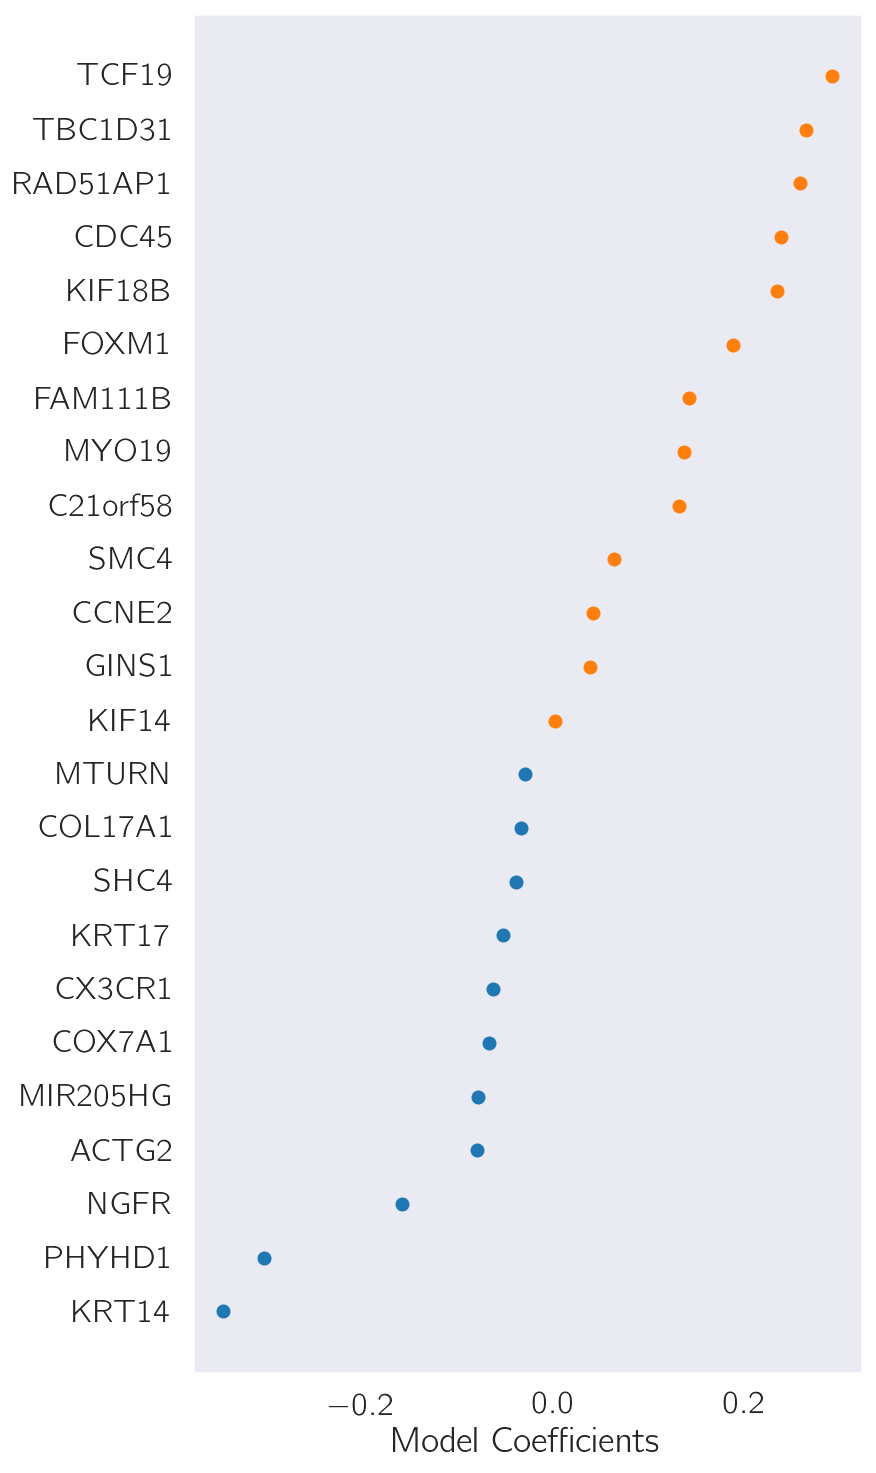

In [9]:
markers = df.index[np.where(models[cval].coef_[0] != 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
ens_mark.sort_values("ensembl_gene_id", inplace=True)

x = models[cval].coef_[0][models[cval].coef_[0] != 0]
sort = np.argsort(x)

fig, ax = plt.subplots(figsize=(6, 12.5))

for i in ['neg', 'pos']:
    if i == 'pos':
        plt.plot(x[sort][x[sort] > 0],
                 ens_mark.external_gene_name.values[sort][x[sort] > 0],
                 'o')
    else:
        plt.plot(x[sort][x[sort] < 0],
                 ens_mark.external_gene_name.values[sort][x[sort] < 0],
                 'o')
_ = plt.xlabel('Model Coefficients')

In [10]:
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:CC,GO:0031261,DNA replication preinitiation complex,0.014340,True,"""A protein-DNA complex assembled at eukaryotic...",12,21,2,18963,0.095238,0.166667,query_1,"[GO:0005654, GO:0032993, GO:0140513]"
1,HP,HP:0007455,Adermatoglyphia,0.017202,True,Adermatoglyphia,4,8,2,4461,0.250000,0.500000,query_1,[HP:0007477]
2,GO:CC,GO:0043232,intracellular non-membrane-bounded organelle,0.025763,True,"""Organized structure of distinctive morphology...",4326,21,13,18963,0.619048,0.003005,query_1,"[GO:0005622, GO:0043228, GO:0043229]"
3,REAC,REAC:R-HSA-446107,Type I hemidesmosome assembly,0.026214,True,Type I hemidesmosome assembly,11,14,2,10531,0.142857,0.181818,query_1,[REAC:R-HSA-446728]
4,GO:CC,GO:0043228,non-membrane-bounded organelle,0.026221,True,"""Organized structure of distinctive morphology...",4333,21,13,18963,0.619048,0.003000,query_1,[GO:0043226]
5,GO:BP,GO:0022402,cell cycle process,0.029336,True,"""The cellular process that ensures successive ...",1447,21,9,18092,0.428571,0.006220,query_1,"[GO:0007049, GO:0009987]"
6,GO:BP,GO:0048285,organelle fission,0.030512,True,"""The creation of two or more organelles by div...",500,21,6,18092,0.285714,0.012000,query_1,[GO:0006996]
7,REAC,REAC:R-HSA-176974,Unwinding of DNA,0.031433,True,Unwinding of DNA,12,14,2,10531,0.142857,0.166667,query_1,[REAC:R-HSA-69190]
8,KEGG,KEGG:04915,Estrogen signaling pathway,0.041379,True,Estrogen signaling pathway,137,11,3,7987,0.272727,0.021898,query_1,[KEGG:00000]
9,GO:MF,GO:0008574,"ATP-dependent microtubule motor activity, plus...",0.044094,True,"""Catalysis of movement along a microtubule tow...",16,21,2,18694,0.095238,0.125000,query_1,[GO:1990939]


In [11]:
markers = df.index[np.where(models[cval].coef_[0] < 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)]
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,HP,HP:0007455,Adermatoglyphia,0.002477,True,Adermatoglyphia,4,4,2,4461,0.500000,0.500000,query_1,[HP:0007477]
1,HP,HP:0007556,Plantar hyperkeratosis,0.002792,True,Hyperkeratosis affecting the sole of the foot.,46,4,3,4461,0.750000,0.065217,query_1,"[HP:0000962, HP:0100872]"
2,REAC,REAC:R-HSA-446107,Type I hemidesmosome assembly,0.002922,True,Type I hemidesmosome assembly,11,6,2,10531,0.333333,0.181818,query_1,[REAC:R-HSA-446728]
3,HP,HP:0007446,Palmoplantar blistering,0.011546,True,A type of blistering that affects the skin of ...,8,4,2,4461,0.500000,0.250000,query_1,"[HP:0040211, HP:0100872]"
4,KEGG,KEGG:04915,Estrogen signaling pathway,0.013138,True,Estrogen signaling pathway,137,8,3,7987,0.375000,0.021898,query_1,[KEGG:00000]
5,HP,HP:0100872,Abnormality of the plantar skin of foot,0.017415,True,"An abnormality of the plantar part of foot, th...",84,4,3,4461,0.750000,0.035714,query_1,"[HP:0001760, HP:0011356]"
6,GO:BP,GO:0031581,hemidesmosome assembly,0.023809,True,"""Assembly of hemidesmosomes, integrin-containi...",12,10,2,18092,0.200000,0.166667,query_1,[GO:0007044]
7,HP,HP:0200097,Oral mucosal blisters,0.032116,True,Blisters arising in the mouth.,13,4,2,4461,0.500000,0.153846,query_1,"[HP:0008066, HP:0011830]"
8,GO:BP,GO:0042303,molting cycle,0.037254,True,"""The periodic casting off and regeneration of ...",114,10,3,18092,0.300000,0.026316,query_1,[GO:0032501]
9,GO:BP,GO:0042633,hair cycle,0.037254,True,"""The cyclical phases of growth (anagen), regre...",114,10,3,18092,0.300000,0.026316,query_1,[GO:0042303]


In [12]:
markers = df.index[np.where(models[cval].coef_[0] > 0)[0]].values
ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)]
sc.queries.enrich(ens_mark.ensembl_gene_id)

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0022402,cell cycle process,0.000009,True,"""The cellular process that ensures successive ...",1447,11,9,18092,0.818182,0.006220,query_1,"[GO:0007049, GO:0009987]"
1,GO:BP,GO:0007049,cell cycle,0.000102,True,"""The progression of biochemical and morphologi...",1914,11,9,18092,0.818182,0.004702,query_1,[GO:0009987]
2,GO:BP,GO:0048285,organelle fission,0.000247,True,"""The creation of two or more organelles by div...",500,11,6,18092,0.545455,0.012000,query_1,[GO:0006996]
3,GO:BP,GO:1903047,mitotic cell cycle process,0.000332,True,"""A process that is part of the mitotic cell cy...",921,11,7,18092,0.636364,0.007600,query_1,"[GO:0000278, GO:0022402]"
4,GO:BP,GO:0000278,mitotic cell cycle,0.000916,True,"""Progression through the phases of the mitotic...",1069,11,7,18092,0.636364,0.006548,query_1,[GO:0007049]
5,GO:CC,GO:0043232,intracellular non-membrane-bounded organelle,0.001775,True,"""Organized structure of distinctive morphology...",4326,12,10,18963,0.833333,0.002312,query_1,"[GO:0005622, GO:0043228, GO:0043229]"
6,GO:CC,GO:0043228,non-membrane-bounded organelle,0.001802,True,"""Organized structure of distinctive morphology...",4333,12,10,18963,0.833333,0.002308,query_1,[GO:0043226]
7,GO:CC,GO:0031261,DNA replication preinitiation complex,0.002725,True,"""A protein-DNA complex assembled at eukaryotic...",12,12,2,18963,0.166667,0.166667,query_1,"[GO:0005654, GO:0032993, GO:0140513]"
8,REAC,REAC:R-HSA-69278,"Cell Cycle, Mitotic",0.002871,True,"Cell Cycle, Mitotic",512,8,5,10531,0.625000,0.009766,query_1,[REAC:R-HSA-1640170]
9,GO:BP,GO:0000280,nuclear division,0.005337,True,"""The division of a cell nucleus into two nucle...",451,11,5,18092,0.454545,0.011086,query_1,[GO:0048285]


In [13]:
ens_mark

,ensembl_gene_id,gene_biotype,external_gene_name,description
9087,ENSG00000160298,protein_coding,C21orf58,chromosome 21 open reading frame 58 [Source:HG...
9655,ENSG00000093009,protein_coding,CDC45,cell division cycle 45 [Source:HGNC Symbol;Acc...
11328,ENSG00000101003,protein_coding,GINS1,GINS complex subunit 1 [Source:HGNC Symbol;Acc...
23462,ENSG00000111206,protein_coding,FOXM1,forkhead box M1 [Source:HGNC Symbol;Acc:HGNC:3...
23986,ENSG00000111247,protein_coding,RAD51AP1,RAD51 associated protein 1 [Source:HGNC Symbol...
25193,ENSG00000137310,protein_coding,TCF19,transcription factor 19 [Source:HGNC Symbol;Ac...
28754,ENSG00000175305,protein_coding,CCNE2,cyclin E2 [Source:HGNC Symbol;Acc:HGNC:1590]
32514,ENSG00000156787,protein_coding,TBC1D31,TBC1 domain family member 31 [Source:HGNC Symb...
50067,ENSG00000189057,protein_coding,FAM111B,family with sequence similarity 111 member B [...
58043,ENSG00000113810,protein_coding,SMC4,structural maintenance of chromosomes 4 [Sourc...


In [14]:
# test feature stability:
reps = []
for i in np.arange(1, 20):
    model = LogisticRegression(
        penalty='l1',
        solver='saga',
        C=cval,
        max_iter=5000,
        random_state=i)
    model.fit(train_exp, train_labels)
    reps += [model]

/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/anaconda3/envs/scanpy/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/davidangeles/opt/

In [23]:
def get_features(data, cond=np.where(models[cval].coef_[0] != 0)[0]):
    markers = data.index.values[cond]
    ens_mark = ensembl[ensembl.ensembl_gene_id.isin(markers)].copy()
    ens_mark.ensembl_gene_id = ens_mark.ensembl_gene_id.astype('category')
    ens_mark.ensembl_gene_id.cat.set_categories(markers, inplace=True)
    ens_mark.sort_values("ensembl_gene_id", inplace=True)
    missing = np.array([0 if m not in ensembl.ensembl_gene_id.values else 1 for m in markers ])
    return ens_mark, missing

genes = []
for r in reps:
    f, miss = get_features(normed, np.where(r.coef_[0] != 0)[0])
    f = f.external_gene_name.values
    genes += f.tolist()

In [25]:
uniq, counts = np.unique(genes, return_counts=True)
print(len(uniq), counts.min(), counts.max())

24 19 19
